In [14]:
from utils.decoders import VAE_Bayesian_MLP_decoder, simple_mlp_decoder
from utils.encoders import simple_mlp_encoder
from utils.mlp import create_nn_sequential_MLP,MLP
from utils.activations import get_activation
from utils.attention import MultiSelfAttention
from utils.priors import MogPrior, VampPrior, kl_divergence_two_gaussians,kl_divergence_gaussian_vs_mog,rho_to_logvar, var_to_rho
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math

def init_all(model, init_func, *params, **kwargs):
    for p in model.parameters():
        if p.requires_grad:
            #rand_int=torch.randint(-2,2,()).item()
            #rand_int=(torch.rand(1).item())*2-1
            #init_func(p, *params, **{k:v+rand_int for k,v in kwargs.items()})
            if p.ndim > 1:# Weight tensors
                init_func(p, *params, **kwargs)
            else: # Biases
                torch.nn.init.constant_(p,0.01)
            #p.data = torch.nn.functional.normalize(p,dim=-1).data
            #torch.nn.utils.weight_norm(p,name='weight',dim=1)

def sample_latent(mu, log_var):
    """
        Samples a latent vector via reparametrization trick
    """
    eps = torch.randn_like(mu, device=mu.device)
    z = torch.exp(0.5*log_var) * eps + mu
    return z
    
def kl_divergence_two_gaussians(mu0, logvar0, mu1, logvar1):
    return 0.5 * torch.sum(logvar1 - logvar0 - 1 + torch.exp(logvar0 - logvar1) + (mu0 - mu1).pow(2) * torch.exp(-logvar1), dim=1)

def get_beta(t):
    return torch.nn.functional.softplus(t)

class VAE(torch.nn.Module):
    def __init__(self,vae_input_size,z_dim,enc_layers,activation_str,
                 vae_dropout_p, layernorm, skipconnections, skiptemperature, num_prior_components, prior_type, vae_prior_init_scaler,latent_moment_n_layers):
        super(VAE, self).__init__()
        self.num_prior_components = num_prior_components
    
        self.vae_encoder = MLP(vae_input_size, enc_layers,z_dim, get_activation(activation_str), 
                                         dropout_p=vae_dropout_p,layernorm=layernorm,skipconnections=skipconnections,skiptemperature=skiptemperature)
        
        self.vae_decoder = MLP(z_dim, enc_layers[::-1],vae_input_size, get_activation(activation_str), 
                                         dropout_p=vae_dropout_p,layernorm=layernorm,skipconnections=skipconnections,skiptemperature=skiptemperature)
        
        self.Prior = MogPrior(z_dim, self.num_prior_components, prior_type, init_scaler=vae_prior_init_scaler)
        beta_min = -8.
        
        self.thebeta = torch.nn.Parameter(torch.tensor(beta_min), requires_grad=True)

        init_all(self.vae_encoder, nn.init.xavier_uniform_, gain=nn.init.calculate_gain(activation_str))
        init_all(self.vae_decoder, nn.init.xavier_uniform_, gain=nn.init.calculate_gain(activation_str))

        mu_bias_init = 0.1
        log_var_bias_init =  -10.0
        
        enc_out_dim = self.vae_encoder.linear_layers[-1].out_features
        enc_layers_latent_moments = enc_layers
        
        if not (latent_moment_n_layers is None):
            enc_layers_latent_moments = [enc_layers[-1]] * latent_moment_n_layers
        
        self.fc_decode = MLP(vae_input_size, enc_layers_latent_moments,z_dim, get_activation(activation_str), 
                                         dropout_p=vae_dropout_p,layernorm=layernorm,skipconnections=skipconnections,skiptemperature=skiptemperature)
       
        self.fc_mu_z = MLP(vae_input_size, enc_layers_latent_moments,z_dim, get_activation(activation_str), 
                                         dropout_p=vae_dropout_p,layernorm=layernorm,skipconnections=skipconnections,skiptemperature=skiptemperature)
                        
        
        self.fc_mixture = MLP(vae_input_size, enc_layers_latent_moments,z_dim, get_activation(activation_str), 
                                         dropout_p=vae_dropout_p,layernorm=layernorm,skipconnections=skipconnections,skiptemperature=skiptemperature)
        
        self.fc_rho_z = MLP(vae_input_size, enc_layers_latent_moments,z_dim, get_activation(activation_str), 
                                         dropout_p=vae_dropout_p,layernorm=layernorm,skipconnections=skipconnections,skiptemperature=skiptemperature)
        
        init_all(self.fc_mu_z, nn.init.xavier_uniform_, gain=nn.init.calculate_gain(activation_str))
        init_all(self.fc_decode, nn.init.xavier_uniform_, gain=nn.init.calculate_gain(activation_str))

        init_all(self.fc_rho_z, nn.init.xavier_uniform_, gain=nn.init.calculate_gain(activation_str))
        
    def forward(self, X, mu=None,log_var=None,stochastic=True):
        if mu is None:           
            mu = self.fc_mu_z(X)
            log_var = rho_to_logvar(self.fc_rho_z(X))
        kl = self.Prior.kl_div(mu, log_var)
        z = sample_latent(mu, log_var)
        logits = self.vae_decoder(z)
        return logits, z, kl, mu, log_var

In [2]:
from utils.GMVAE import GMVAENet

In [3]:
from sklearn.datasets import make_moons
import sys 


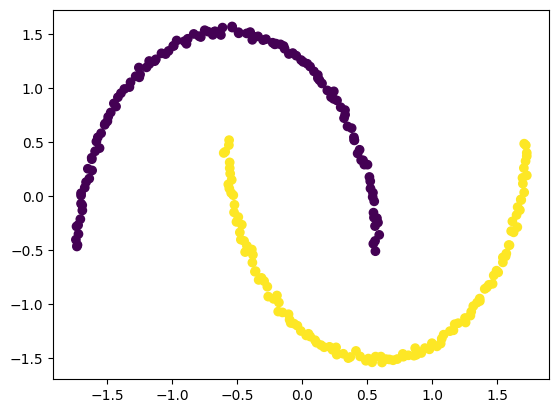

In [4]:

loss_func = torch.nn.MSELoss(reduction="none")
N = 256

X, y = make_moons(n_samples=N, noise=0.01, random_state=42)
X=torch.from_numpy(X).to(torch.float32)
X = (X-X.mean(0))/X.std(0)
fig, ax = plt.subplots()
ax.scatter(*X.detach().T,c=y)


In [5]:
model = GMVAENet(2,2,2,h_dim=2)
out = model(X)
out.keys()
out["gaussian"].shape

torch.Size([256, 2])

0.01
0.01


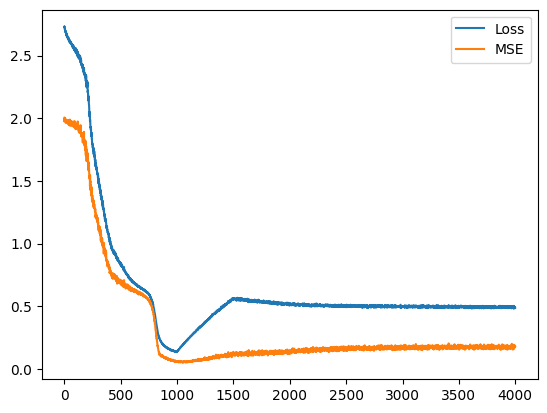

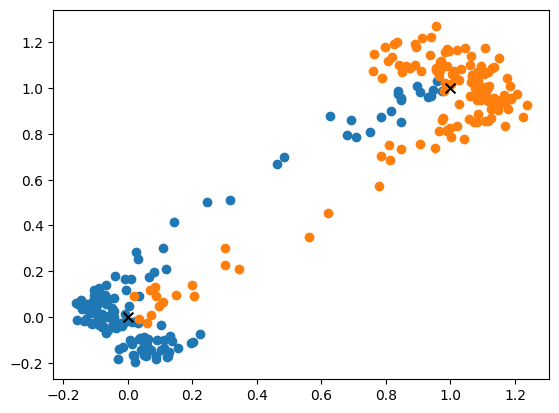

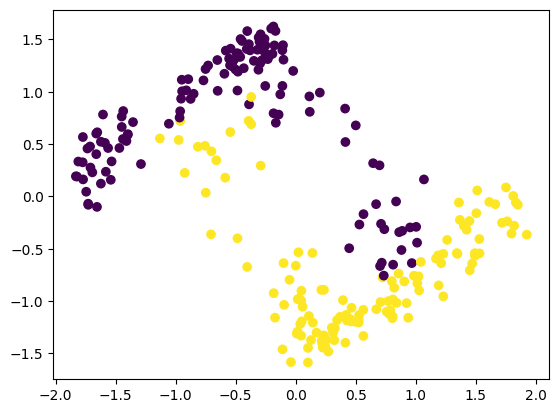

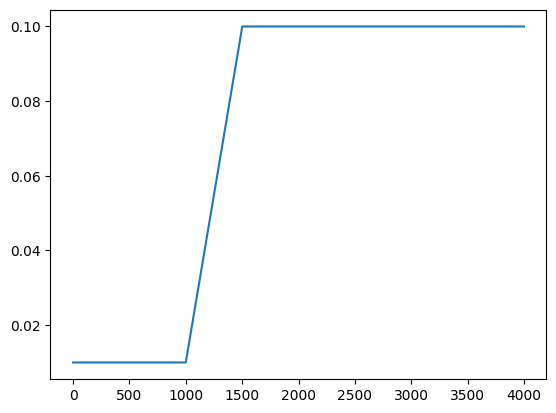

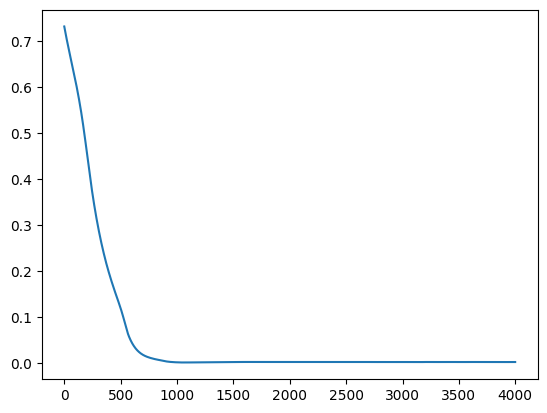

In [32]:
vae_input_size = 2
z_dim = 2
enc_layers = [2]*3

prior_type = "mog_fixmeanfixvar"
#prior_type = "mog_fixmean"

activation_str = "selu"
vae_activation = get_activation(activation_str)
vae_latent_activation = get_activation(activation_str)
vae_dropout_p = 0

layernorm = False
skipconnections = False
skiptemperature = False

d = vae_input_size
latent_moment_n_layers = None
num_prior_components = 2
vae_prior_init_scaler = .01

torch.manual_seed(0)
model = VAE(vae_input_size, z_dim, enc_layers, activation_str, 
            vae_dropout_p, layernorm, skipconnections,skiptemperature,
            num_prior_components, prior_type, vae_prior_init_scaler, latent_moment_n_layers)
#model = GMVAENet(2,2,2,h_dim=2)
#model(X).keys()

Xpriors = []
#fig, ax = plt.subplots()
#for m in range(model.Prior.num_components):
#    mu,log_var = model.Prior.prior_means[0, :, m].detach(), rho_to_logvar(model.Prior.prior_rhos)[0, :, m].exp().detach()
#    Xpriors.append(torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=log_var.diag()).rsample((N,)))
#    ax.scatter(*Xpriors[m].T, label=str(m))

lr = 1e-3
Loss = []
KL = []
MSE = []
Annealing = []
BETA = []
Var = []
beta_min = 0.01
beta_max = 0.1

L = 3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
n_epochs = 4000

epoch_beta_start = 1000#n_epochs // 10
epoch_beta_end = 1500
found_nans = False

stochastic=False

for epoch in range(n_epochs):

    batch = X
    optimizer.zero_grad()

    if (epoch > epoch_beta_start):   # and ((epoch%2)==0):
        # How far from start_beta
        alpha = min([1,( (epoch - epoch_beta_start)/(epoch_beta_end-epoch_beta_start))])

        annealing_beta = torch.tensor(beta_max) * alpha +  torch.tensor(beta_min) * (1-alpha) 
        stochastic=True
        #model.vae_encoder.requires_grad_(False)
        #model.vae_decoder.requires_grad_(False)
    else:
        # Ignore KL div 
        annealing_beta = torch.tensor(beta_min)
    #annealing_beta = 1
    Annealing.append(annealing_beta)
    
    loss = 0.
    mu, log_var = None, None
    for _ in range(L):
        logits, z, kl, mu, log_var = model(batch, mu=mu, log_var=log_var,stochastic=stochastic)
        #log_var = (vae_prior_init_scaler * torch.ones(1, z_dim, num_prior_components)).log()

        #out = model(batch)
        #logits = out["x_rec"]
        #mu=out["mean"]
        #log_var=out["var"].log()
        
        #z = out["gaussian"]
        #kl = kl_divergence_two_gaussians(mu,log_var,out["y_mean"],out["y_var"].log())
        
        mse_loss = loss_func(X, logits).sum(1)
        beta = annealing_beta#beta_min + get_beta(model.thebeta)
        #loss = (1-beta)*mse_loss + kl*beta
        loss += kl*beta
        #if epoch>(n_epochs//2):
        loss += mse_loss
            
        if loss.mean().isnan():
            print("Loss", loss.isnan().any(), "MSE", mse_loss.isnan().any(), "KL", kl.isnan().any())
            found_nans = True
            break
    Var.append(log_var.detach().exp().mean())
    if found_nans:
        print("NANS")
        break
    loss = loss.mean()/L
    loss.backward()
    optimizer.step()

    Loss.append(loss.item())
    MSE.append(mse_loss.mean().item())
    KL.append(kl.mean().item())
    BETA.append(beta.item())

fig, ax = plt.subplots()
ax.plot(Loss, label="Loss")
#ax.plot(KL, label="KL")
ax.plot(MSE, label="MSE")
ax.legend()

fig, ax = plt.subplots()
ax.scatter(*z[y==0].detach().T)
ax.scatter(*z[y==1].detach().T)
for mean in model.Prior.prior_means[0].T:
    ax.scatter(mean[0].detach(),mean[1].detach(),c="black",marker="x",s=50)
    #ax.scatter(*model.Prior.prior_means[0,:,[1]].tolist(),c="black",marker="x",size=10)

fig, ax = plt.subplots()
ax.scatter(*logits.detach().T, c=y)

fig, ax = plt.subplots()
ax.plot(BETA)

fig, ax = plt.subplots()
ax.plot(Var)

In [7]:
model

VAE(
  (vae_encoder): MLP(
    (dropout_function): Dropout(p=0, inplace=False)
    (activation_function): ActivationWrapper(
      selu
      (activation_fun): SELU()
    )
    (linear_layers): ModuleList(
      (0-2): 3 x Linear(in_features=2, out_features=2, bias=True)
    )
  )
  (vae_decoder): MLP(
    (dropout_function): Dropout(p=0, inplace=False)
    (activation_function): ActivationWrapper(
      selu
      (activation_fun): SELU()
    )
    (linear_layers): ModuleList(
      (0-2): 3 x Linear(in_features=2, out_features=2, bias=True)
    )
  )
  (Prior): MogPrior()
  (fc_decode): MLP(
    (dropout_function): Dropout(p=0, inplace=False)
    (activation_function): ActivationWrapper(
      selu
      (activation_fun): SELU()
    )
    (linear_layers): ModuleList(
      (0-2): 3 x Linear(in_features=2, out_features=2, bias=True)
    )
  )
  (fc_mu_z): MLP(
    (dropout_function): Dropout(p=0, inplace=False)
    (activation_function): ActivationWrapper(
      selu
      (activation

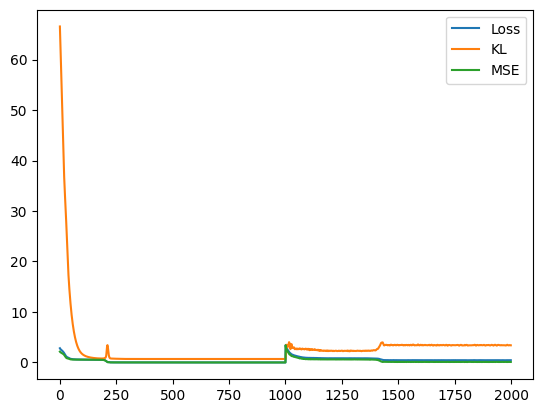

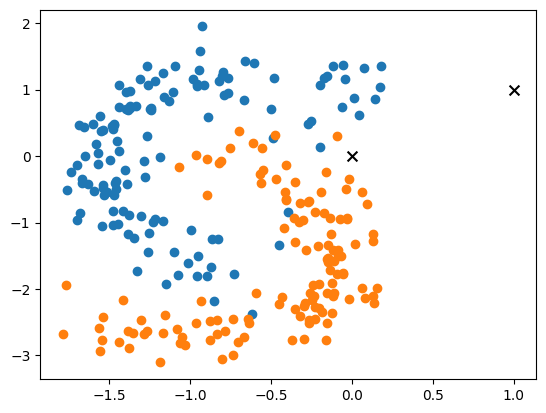

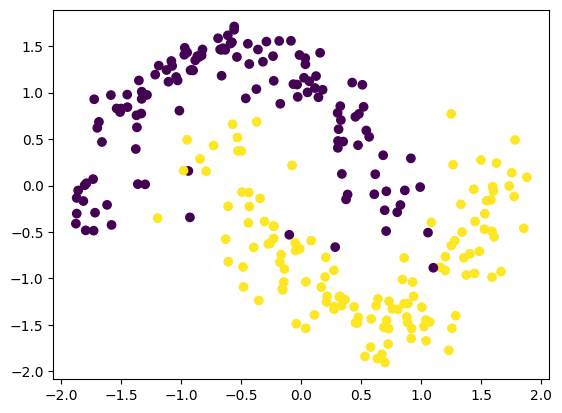

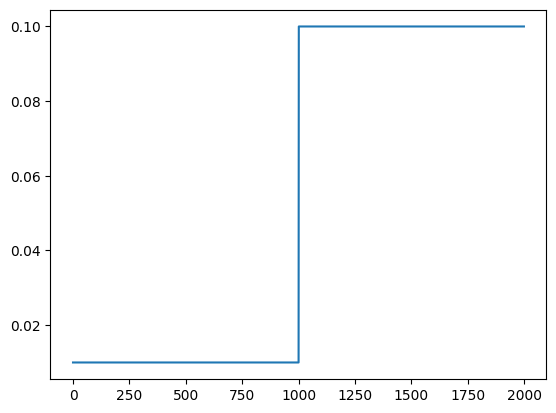

In [10]:

fig, ax = plt.subplots()
ax.plot(Loss, label="Loss")
ax.plot(KL, label="KL")
ax.plot(MSE, label="MSE")
ax.legend()

fig, ax = plt.subplots()
ax.scatter(*z[y==0].detach().T)
ax.scatter(*z[y==1].detach().T)
for mean in model.Prior.prior_means[0].T:
    ax.scatter(mean[0].detach(),mean[1].detach(),c="black",marker="x",s=50)
    #ax.scatter(*model.Prior.prior_means[0,:,[1]].tolist(),c="black",marker="x",size=10)

fig, ax = plt.subplots()
ax.scatter(*logits.detach().T, c=y)

fig, ax = plt.subplots()
ax.plot(BETA)

In [11]:
y_hat

NameError: name 'y_hat' is not defined

In [ ]:

tmp[2]

In [ ]:
for p in model.parameters():
    #if (p == model.thebeta).all():
    print(p)